In [1]:
import numpy as np
import pandas as pd
from datetime import date
from nsepy import get_history
from nsepy.derivatives import get_expiry_date

In [2]:
# Getting historical Nifty data.

df1 = get_history(symbol = "NIFTY", start = date(2021,1,1), end = date(2022,1,10), index = True)

# Get rid of columns which are of no use to us.

df1.drop(columns=['Open', 'High', 'Low', 'Volume', 'Turnover'], inplace = True)

# Reset df index making it easier for us to use the dataframe

df1.reset_index(inplace=True)

# See all the columns and create a duplicate dataframes.

df1.columns

# We will now create an empty dataframe, and only keep thursday values.

## For those who do not understand, NSE Derivatives expire every Thursday.

### So we will filter out Thursday, effectively getting us every expiry.

df2 = pd.DataFrame(data = None, columns = ['Date', 'Close'])

# Let's filter


for i in range(len(df1)):
    
    # We use weekday as 3 because Thursday in datetime library is encoded as 3.
    
    if date.weekday(df1['Date'][i]) == 3:
        
        df2 = pd.concat([df2, pd.DataFrame.from_records([dict(df1.loc[df1.index[i]])])])
        
# Let's check our dataframe

df2

# We have a pesky index. It is out of order. Let's get rid of it.
df2.reset_index(inplace = True)
df2.drop(axis = 1, columns=['index'], inplace=True)

In [3]:
df2

,Date,Close
0,2021-01-07,14137.35
1,2021-01-14,14595.6
2,2021-01-21,14590.35
3,2021-01-28,13817.55
4,2021-02-04,14895.65
5,2021-02-11,15173.3
6,2021-02-18,15118.95
7,2021-02-25,15097.35
8,2021-03-04,15080.75
9,2021-03-18,14557.85


In [8]:
pd.options.mode.chained_assignment = None 

# Our dataframe is almost ready. We have a final thing to do.

# We do not know if all the dates we have are actual expiries or not. 
## When we get historical data using 'nsepy', it has a attribute called 'expiry'. We will keep feeding it
## closest strike prices. If we keep getting values, it means the expiry is correct. If we don't it means
## the expiry is incorrect and we need to correct the expiry.

### Note: Thursdays can sometimes be holidays, in which case prior Wednesdays are treated as expiries.

# Let us first get the closest possible strike prices. This will also be benefical to us when creating straddles.

# Create a dummy row

df2['Straddle Strikes'] = range(len(df2))

# Create a list of strikes

strikes = range(12000, 19000, 50)

count = 0

for i in df2['Close']:
    for j in strikes:
        if j < i:
            pass
        else:
            break
    upperstrike = j
    lowerstrike = j - 50
    
    if abs(upperstrike - i) < abs(lowerstrike - i):
        df2['Straddle Strikes'].iloc[count] = upperstrike
#         print(f"Straddle Strike: {upperstrike}.")
    else:
        df2['Straddle Strikes'].iloc[count] = lowerstrike
#         print(f"Straddle Strike: {lowerstrike}.")
        
    count += 1

In [9]:
# Great! We now have the strike prices. Let us exception handling to see if any dates are not actual expiries.

for i in range(len(df2)):
    try:
        get_history(symbol="NIFTY", start=df2['Date'].iloc[i], end=df2['Date'].iloc[i], index=True, option_type='CE', strike_price=int(df2['Straddle Strikes'].iloc[i]), expiry_date=df2['Date'].iloc[i]).iloc[0]['Last']
    except:
        print(df2['Date'].iloc[i])
        
        
# So our culprit is 2021-11-04

## Let us see of 2021-11-03 works

get_history(symbol="NIFTY", start=date(2021,11,3) , end=date(2021,11,3), index=True, option_type='CE', strike_price=int(df2['Straddle Strikes'].iloc[i]), expiry_date=date(2021,11,3)).iloc[0]['Last']

# It does!

# So it is time to replace 4 with 3.

df2.iat[40, 0] = date(2021, 11, 3) # iat is indexat. It will give you a single value instead of iloc giving you entire row

In [10]:
# We also need end dates with 'get_history'

df2['Entry Date'] = range(len(df2))
df2['Exit Date'] = range(len(df2))

for i in range(len(df2) - 1):
    entry_date = df2['Date'][i]
    df2['Entry Date'].iloc[i] = entry_date
    exit_date = df2['Date'][i+1]
    df2['Exit Date'].iloc[i] = exit_date
    

In [11]:
# Fantastic. We now have strikes, entry date and exit dates.

# Now all we need are CE and PE entry values.

df2['ce_entry'] = range(len(df2))
df2['pe_entry'] = range(len(df2))

for i in range(len(df2)-1):
    start_date = df2.iloc[i]['Entry Date']
    exit_date = df2.iloc[i]['Exit Date']
    ce_entry = get_history(symbol="NIFTY", start=start_date, end=exit_date, index=True, option_type='CE', strike_price=int(df2['Straddle Strikes'].iloc[i]), expiry_date=df2['Exit Date'].iloc[i]).iloc[0]['Last']
    pe_entry = get_history(symbol="NIFTY", start=start_date, end=exit_date, index=True, option_type='PE', strike_price=int(df2['Straddle Strikes'].iloc[i]), expiry_date=df2['Exit Date'].iloc[i]).iloc[0]['Last']
    df2['ce_entry'].iloc[i] = ce_entry
    df2['pe_entry'].iloc[i] = pe_entry

    
df2

,Date,Close,Straddle Strikes,Entry Date,Exit Date,ce_entry,pe_entry
0,2021-01-07,14137.35,14150,2021-01-07,2021-01-14,141.60,112.70
1,2021-01-14,14595.6,14600,2021-01-14,2021-01-21,146.00,127.00
2,2021-01-21,14590.35,14600,2021-01-21,2021-01-28,163.45,123.65
3,2021-01-28,13817.55,13800,2021-01-28,2021-02-04,237.25,212.00
4,2021-02-04,14895.65,14900,2021-02-04,2021-02-11,143.90,177.00
5,2021-02-11,15173.3,15150,2021-02-11,2021-02-18,164.05,120.00
6,2021-02-18,15118.95,15100,2021-02-18,2021-02-25,154.90,135.00
7,2021-02-25,15097.35,15100,2021-02-25,2021-03-04,178.00,132.55
8,2021-03-04,15080.75,15100,2021-03-04,2021-03-18,280.00,291.40
9,2021-03-18,14557.85,14550,2021-03-18,2021-03-25,213.00,162.00


In [12]:
# Let's not keep our positions unhedged.

# Historically speaking, 70% of the times, Nifty doesn't move more than 2.20570% in a week.
# So let's determine our hedged strikes using this.

df2['ce_hedge_strikes'] = range(len(df2))
df2['pe_hedge_strikes'] = range(len(df2))

movement = 2.20570/100

for i in range(len(df2)-1):
    close = df2['Close'].iloc[i]
    upper_range = close + close * movement
    lower_range = close - close * movement
    
    for j in strikes:
        if j < upper_range:
            pass
        else:
            break
    upperstrike = j
    lowerstrike = j - 50

    if abs(upperstrike - upper_range) < abs(lowerstrike - upper_range):
        df2['ce_hedge_strikes'].iloc[i] = upperstrike
#         print(f"Straddle Strike: {upperstrike}.")
    else:
        df2['ce_hedge_strikes'].iloc[i] = lowerstrike
#         print(f"Straddle Strike: {lowerstrike}.")

    for j in strikes:
        if j < lower_range:
            pass
        else:
            break
    upperstrike = j
    lowerstrike = j - 50

    if abs(upperstrike - upper_range) > abs(lowerstrike - upper_range):
        df2['pe_hedge_strikes'].iloc[i] = upperstrike
#         print(f"Straddle Strike: {upperstrike}.")
    else:
        df2['pe_hedge_strikes'].iloc[i] = lowerstrike
#         print(f"Straddle Strike: {lowerstrike}.")



In [13]:
# Fantastic. We now have strikes, entry date and exit dates.

# Now all we need are CE and PE entry values.

df2['ce_hedge_entry'] = range(len(df2))
df2['pe_hedge_entry'] = range(len(df2))

for i in range(len(df2)-1):
    start_date = df2.iloc[i]['Entry Date']
    exit_date = df2.iloc[i]['Exit Date']
    ce_entry = get_history(symbol="NIFTY", start=start_date, end=exit_date, index=True, option_type='CE', strike_price=int(df2['ce_hedge_strikes'].iloc[i]), expiry_date=df2['Exit Date'].iloc[i]).iloc[0]['Last']
    pe_entry = get_history(symbol="NIFTY", start=start_date, end=exit_date, index=True, option_type='PE', strike_price=int(df2['pe_hedge_strikes'].iloc[i]), expiry_date=df2['Exit Date'].iloc[i]).iloc[0]['Last']
    df2['ce_hedge_entry'].iloc[i] = ce_entry
    df2['pe_hedge_entry'].iloc[i] = pe_entry

    
df2

,Date,Close,Straddle Strikes,Entry Date,Exit Date,ce_entry,pe_entry,ce_hedge_strikes,pe_hedge_strikes,ce_hedge_entry,pe_hedge_entry
0,2021-01-07,14137.35,14150,2021-01-07,2021-01-14,141.60,112.70,14450,13800,26.00,30.00
1,2021-01-14,14595.6,14600,2021-01-14,2021-01-21,146.00,127.00,14900,14250,30.40,36.55
2,2021-01-21,14590.35,14600,2021-01-21,2021-01-28,163.45,123.65,14900,14250,37.50,47.00
3,2021-01-28,13817.55,13800,2021-01-28,2021-02-04,237.25,212.00,14100,13500,112.00,99.10
4,2021-02-04,14895.65,14900,2021-02-04,2021-02-11,143.90,177.00,15200,14550,40.50,58.00
5,2021-02-11,15173.3,15150,2021-02-11,2021-02-18,164.05,120.00,15500,14800,31.00,34.95
6,2021-02-18,15118.95,15100,2021-02-18,2021-02-25,154.90,135.00,15450,14750,29.95,41.00
7,2021-02-25,15097.35,15100,2021-02-25,2021-03-04,178.00,132.55,15450,14750,45.00,37.50
8,2021-03-04,15080.75,15100,2021-03-04,2021-03-18,280.00,291.40,15400,14700,143.00,149.20
9,2021-03-18,14557.85,14550,2021-03-18,2021-03-25,213.00,162.00,14900,14200,64.10,62.00


In [14]:
# Here comes the fun part! Let us get some PNLs!

df2['ce_pnl'] = range(len(df2))
df2['pe_pnl'] = range(len(df2))

df2['ce_hedge_pnl'] = range(len(df2))
df2['pe_hedge_pnl'] = range(len(df2))

for i in range(len(df2) - 1):
    straddle_strike = df2['Straddle Strikes'].iloc[i]
    ce_entry = df2['ce_entry'].iloc[i]
    pe_entry = df2['pe_entry'].iloc[i]
    
    exit_price = df2['Close'].iloc[i+1]

    if exit_price > straddle_strike:
        ce_pnl = ce_entry - exit_price + straddle_strike
        pe_pnl = pe_entry
    else:
        ce_pnl = ce_entry
        pe_pnl = pe_entry - straddle_strike + exit_price
        
    df2['ce_pnl'].iloc[i] = ce_pnl
    df2['pe_pnl'].iloc[i] = pe_pnl
    
    ce_hedge_strike = df2['ce_hedge_strikes'].iloc[i]
    ce_hedge_entry = df2['ce_hedge_entry'].iloc[i]
    pe_hedge_strike = df2['pe_hedge_strikes'].iloc[i]
    pe_hedge_entry = df2['pe_hedge_entry'].iloc[i]

    if exit_price > ce_hedge_strike:
        ce_hedge_pnl =  exit_price - ce_hedge_strike - ce_hedge_entry
        pe_hedge_pnl = pe_hedge_entry*-1
    elif exit_price < pe_hedge_strike:
        ce_hedge_pnl = ce_hedge_entry*-1
        pe_hedge_pnl =  pe_hedge_strike - exit_price - pe_hedge_entry
    else:
        ce_hedge_pnl = ce_hedge_entry*-1
        pe_hedge_pnl = pe_hedge_entry*-1
        
    df2['ce_hedge_pnl'].iloc[i] = ce_hedge_pnl
    df2['pe_hedge_pnl'].iloc[i] = pe_hedge_pnl

In [15]:
df2

,Date,Close,Straddle Strikes,Entry Date,Exit Date,ce_entry,pe_entry,ce_hedge_strikes,pe_hedge_strikes,ce_hedge_entry,pe_hedge_entry,ce_pnl,pe_pnl,ce_hedge_pnl,pe_hedge_pnl
0,2021-01-07,14137.35,14150,2021-01-07,2021-01-14,141.60,112.70,14450,13800,26.00,30.00,-304.00,112.70,119.60,-30.00
1,2021-01-14,14595.6,14600,2021-01-14,2021-01-21,146.00,127.00,14900,14250,30.40,36.55,146.00,117.35,-30.40,-36.55
2,2021-01-21,14590.35,14600,2021-01-21,2021-01-28,163.45,123.65,14900,14250,37.50,47.00,163.45,-658.80,-37.50,385.45
3,2021-01-28,13817.55,13800,2021-01-28,2021-02-04,237.25,212.00,14100,13500,112.00,99.10,-858.40,212.00,683.65,-99.10
4,2021-02-04,14895.65,14900,2021-02-04,2021-02-11,143.90,177.00,15200,14550,40.50,58.00,-129.40,177.00,-40.50,-58.00
5,2021-02-11,15173.3,15150,2021-02-11,2021-02-18,164.05,120.00,15500,14800,31.00,34.95,164.05,88.95,-31.00,-34.95
6,2021-02-18,15118.95,15100,2021-02-18,2021-02-25,154.90,135.00,15450,14750,29.95,41.00,154.90,132.35,-29.95,-41.00
7,2021-02-25,15097.35,15100,2021-02-25,2021-03-04,178.00,132.55,15450,14750,45.00,37.50,178.00,113.30,-45.00,-37.50
8,2021-03-04,15080.75,15100,2021-03-04,2021-03-18,280.00,291.40,15400,14700,143.00,149.20,280.00,-250.75,-143.00,-7.05
9,2021-03-18,14557.85,14550,2021-03-18,2021-03-25,213.00,162.00,14900,14200,64.10,62.00,213.00,-63.10,-64.10,-62.00


In [16]:
# Let's drop the last row.

df2.drop([49], inplace=True)

In [17]:
df2['Gross Return'] = df2[['ce_pnl', 'pe_pnl', 'ce_hedge_pnl', 'pe_hedge_pnl']].sum(axis = 1)

In [19]:
df2['Date'] = pd.to_datetime(df2['Date'])

df2['Lot Size'] = range(len(df2))

# We need to explicitly define lot size since Nifty lot size changed in July from 75 to 50
for i in range(len(df2)):
    if df2.iloc[i]['Date'].month < 7:
        df2['Lot Size'].iloc[i] = 75
    if df2.iloc[i]['Date'].month >= 7:
        df2['Lot Size'].iloc[i] = 50

In [20]:
df2['Net Return'] = df2['Gross Return'] * df2['Lot Size']

In [25]:
# We will deduct 200 from every trade as brokerage.

df2['Net Return'] = df2['Net Return'] - 200

In [26]:
df2['Net Return'].sum()

78491.24999999981

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:xlabel='Date', ylabel='Net Return'>

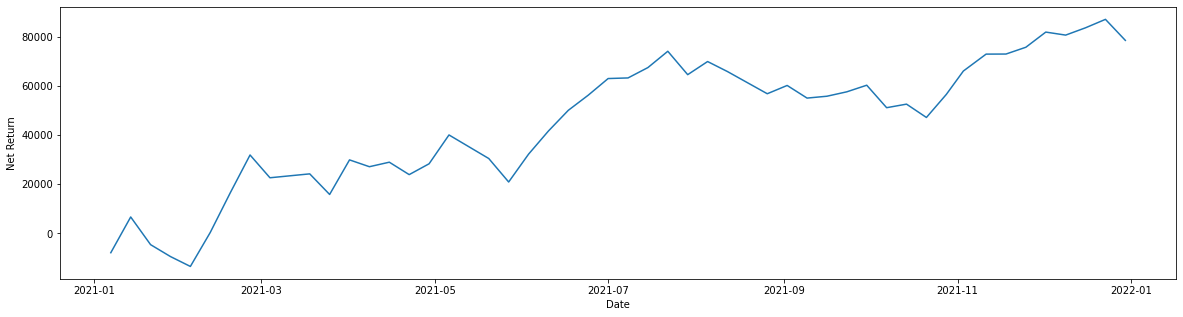

In [28]:
plt.figure(figsize = (20, 5))

sns.lineplot(x = df2['Date'], y = df2['Net Return'].cumsum())

In [ ]:
# Let's simulate it with a portfolio of 100,000.

In [29]:
df2['Portfolio Value'] = df2['Net Return']

In [30]:
df2.at[0, 'Portfolio Value'] = 100000 + df2.at[0, 'Portfolio Value']

In [31]:
df2['Portfolio Value'] = df2['Portfolio Value'].cumsum()

In [38]:
print(f"Peak portfolio value: {df2['Portfolio Value'].max()}")

Peak portfolio value: 187041.2499999998


In [39]:
print(f"Max drawdown: {df2['Net Return'].min()}")

Max drawdown: -11255.000000000024


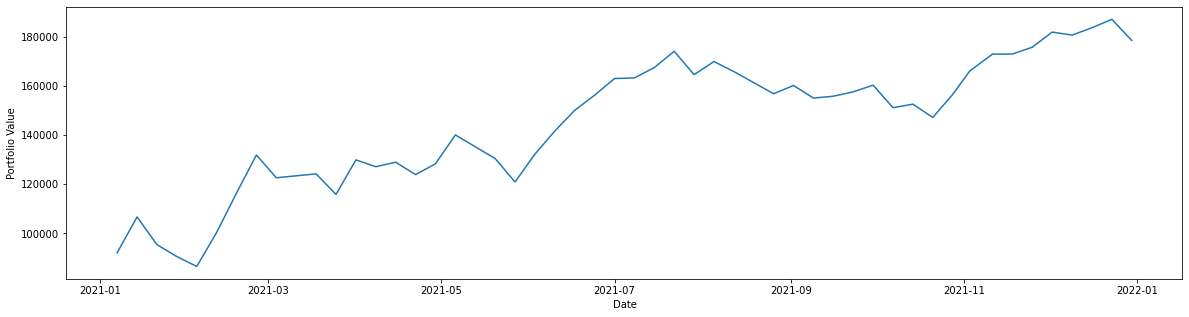

In [69]:
plt.figure(figsize = (20, 5))

line_plot = sns.lineplot(x = df2['Date'], y = df2['Portfolio Value'])